# **炒股有风险，投资需谨慎！！！**

In [1]:
# 导入tushare
import tushare as ts
# 初始化pro接口
pro = ts.pro_api('添加自己的API')

# 拉取数据
df = pro.daily(**{
    "ts_code": "600519.SH", #贵州茅台，可以换成别的
    "trade_date": "",
    "start_date": 20020101,   #开始时间
    "end_date": 20241028,     #结束时间
    "offset": "",
    "limit": ""
}, fields=[
    "trade_date",
    "open",
    "high",
    "low",
    "close",
    "vol"
])
df.set_index('trade_date', inplace=True)
print(df)

               open     high      low    close       vol
trade_date                                              
20241028    1560.00  1565.00  1522.23  1565.00  39121.40
20241025    1547.00  1574.79  1546.01  1558.85  27745.08
20241024    1561.00  1575.00  1545.01  1552.20  23922.80
20241023    1544.11  1576.95  1532.00  1567.50  40088.46
20241022    1526.56  1560.18  1524.20  1543.00  36269.13
...             ...      ...      ...      ...       ...
20020110      36.98    37.39    36.35    37.24  18815.55
20020109      36.50    37.18    36.35    36.87  10606.82
20020108      37.00    37.59    36.48    36.59  13286.64
20020107      37.15    37.50    36.68    37.35  18942.95
20020104      38.72    38.80    37.45    37.55  29109.62

[5459 rows x 5 columns]


In [2]:
def Stock_Price_LSTM_Data_precesing(df, mem_his_days, pre_days):
    
    df.dropna(inplace=True)
    df = df.iloc[::-1].reset_index(drop=True)

    df['label'] = df['close'].shift(-pre_days)

    #数据预处理，数据标准化
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:,:-1])

    from collections import deque
    deq = deque(maxlen=mem_his_days)
    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq) == mem_his_days:
            X.append(list(deq))
    X_lately = X[-pre_days:]
    X = X[:-pre_days]

    y = df['label'].values[mem_his_days-1:-pre_days]

    import numpy as np
    X = np.array(X)
    y = np.array(y)
    X_lately = np.array(X_lately)   #X_lately是最近的pre_days天的数据,用于预测未来pre_days天的股价，不参与训练和测试。

    return X,y,X_lately 
 

In [3]:
X,y,X_lately = Stock_Price_LSTM_Data_precesing(df,5,2)

In [4]:
### 选择最优模型 ###

# pre_days = 2
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dense_layers = [1,2,3]
# units = [16,32]

###最优模型###
pre_days = 2
mem_days = [5]
lstm_layers = [5]
dense_layers = [1]
units = [32]

from tensorflow.keras.callbacks import ModelCheckpoint    #通过callbacks选取最优模型

for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
            #   filepath = '...\\models\\model\\{val_mape:.2f}_{epoch:02d}_' + f'mem_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}.keras'  #试参数时用这个
                filepath = '...\\models\\best\\{val_mape:.2f}_{epoch:02d}_' + f'mem_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}.keras'   #最优参数时用这个
                checkpoint = ModelCheckpoint(
                    filepath = filepath, 
                    save_weights_only= False,  #可以先填True加快模型训练速度，找到最优参数以后改成False运行出最优模型
                    monitor='val_mape', 
                    mode='min',
                    save_best_only=True)
                        
                X,y,X_lately = Stock_Price_LSTM_Data_precesing(df,the_mem_days,pre_days)
                from sklearn.model_selection import train_test_split
                X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.1)

                import tensorflow as tf 
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                model = Sequential()
                model.add(LSTM(the_units,input_shape=(X.shape[1:]),activation='tanh',return_sequences=True, recurrent_activation = 'sigmoid'))
                model.add(Dropout(0.1))

                for i in range(the_lstm_layers):    
                    model.add(LSTM(the_units,activation='tanh',return_sequences=True,recurrent_activation = 'sigmoid'))
                    model.add(Dropout(0.1))

                model.add(LSTM(10,activation='tanh',recurrent_activation = 'sigmoid'))
                model.add(Dropout(0.1))

                for i in range (the_dense_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))
                #评价函数的选择**
                model.compile(optimizer='adam',loss='mse',metrics=['mape'])

                model.fit(X_train,y_train,epochs=60,batch_size=64,validation_data=(X_test,y_test),callbacks=[checkpoint])

Epoch 1/60
77/77 [==============================] - 9s 32ms/step - loss: 498469.6562 - mape: 97.9324 - val_loss: 2864968.2500 - val_mape: 99.6175
Epoch 2/60
77/77 [==============================] - 1s 15ms/step - loss: 490958.9688 - mape: 88.7737 - val_loss: 2829506.0000 - val_mape: 98.9896
Epoch 3/60
77/77 [==============================] - 1s 14ms/step - loss: 480586.4062 - mape: 77.0705 - val_loss: 2778683.2500 - val_mape: 98.0829
Epoch 4/60
77/77 [==============================] - 1s 14ms/step - loss: 466687.4375 - mape: 71.6547 - val_loss: 2712011.5000 - val_mape: 96.8806
Epoch 5/60
77/77 [==============================] - 1s 14ms/step - loss: 449751.8438 - mape: 76.6086 - val_loss: 2632346.0000 - val_mape: 95.4243
Epoch 6/60
77/77 [==============================] - 1s 14ms/step - loss: 431678.5938 - mape: 85.3728 - val_loss: 2542596.7500 - val_mape: 93.7568
Epoch 7/60
77/77 [==============================] - 1s 14ms/step - loss: 413252.6250 - mape: 98.1990 - val_loss: 2446510.250

In [6]:
from tensorflow.keras.models import load_model
best_model = load_model('...models\\best\\2.34_52_mem_5_lstm_5_dense_1_unit_32.keras')  #加载最优模型

In [7]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4864      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 32)             8320      
                                                                 
 dropout_1 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 32)             8320      
                                                                 
 dropout_2 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 5, 32)             8

In [8]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)

18/18 [==============================] - 1s 12ms/step


In [9]:
print(len(y_test))
print(len(pre))


546
546


Index(['20040423', '20040422', '20040421', '20040420', '20040419', '20040416',
       '20040415', '20040414', '20040413', '20040412',
       ...
       '20020117', '20020116', '20020115', '20020114', '20020111', '20020110',
       '20020109', '20020108', '20020107', '20020104'],
      dtype='object', name='trade_date', length=546)


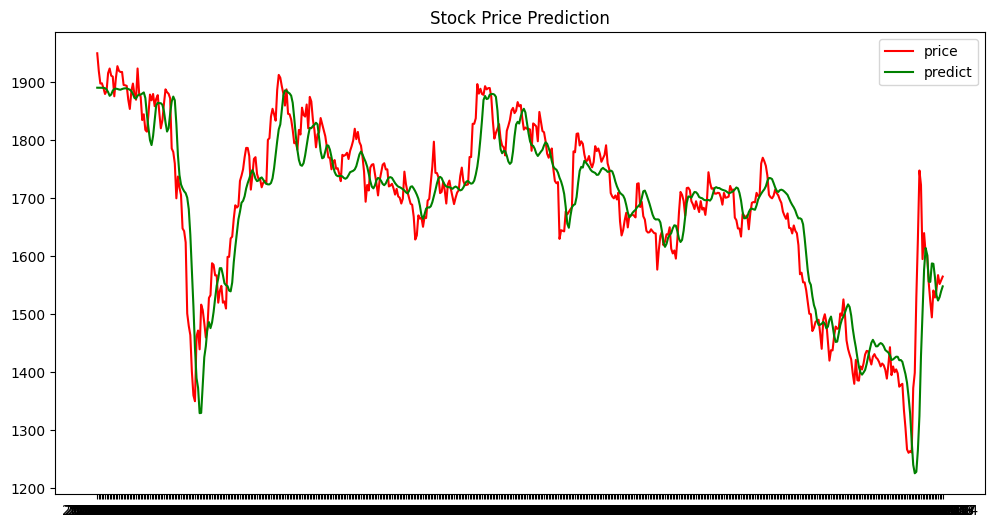

In [10]:
import matplotlib.pyplot as plt

# 设置图表大小
plt.figure(figsize=(12, 6))  # 宽度为 12 英寸，高度为 6 英寸

# 提取 x 轴数据
df_time = df.index[-len(y_test):]
print(df_time)

# 绘制真实值和预测值
plt.plot(df_time, y_test, color='red', label='price')  # 真实值
plt.plot(df_time, pre, color='green', label='predict')  # 预测值

# 设置图表属性
plt.title('Stock Price Prediction')  # 设置图表标题
plt.legend()  # 显示图例
plt.show()

In [11]:
result = best_model.predict(X_lately)  #如果拉取的数据是最新的，这个结果就是预测出来的下一个交易日和下下个交易日的收盘价。
print(result)

1/1 [==============================] - 0s 16ms/step
[[1563.8627]
 [1568.5587]]
